# Многорукие бандиты для задачи блокировок РКО счета после его открытия в течение 6ти месяцев.

Цель состоит в том, чтобы создать автоматическую систему обучения с подкреплением для управления системой открытия счета РКО для клиента.
Идея состоит в том, клиент обращается в банк для открытия РКО счета, однако это может быть фиктивное открытие, которое заблокируется в течение 60 дней. На основе истории о клиенте мы можем понять заблокируется счет РКО или нет, система открывает счет (действие 1) или не открывает (действие 0).
Поэтому система обучения с подкреплением имеет **два возможных действия**.

С другой стороны, полученная награда:

- 0, если система не открывает счет РКО
- 1, если система открывает счет РКО и он **не блокируется**
- -10, если система открывает счет РКО и он **блокируется**

In [1]:
#!pip install pandas scikit-learn category_encoders space_bandits contextualbandits tqdm numpy matplotlib pyyaml seaborn

In [2]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from category_encoders import CatBoostEncoder

from space_bandits import LinearBandits

from sklearn.linear_model import LogisticRegression
from copy import deepcopy

from tqdm import tqdm
import yaml
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sn
from pylab import rcParams

%matplotlib inline
matplotlib.rc('figure', figsize=(15, 4))

import warnings

pd.options.display.max_colwidth = 200
warnings.filterwarnings("ignore")

SEED = 42

/opt/anaconda3/envs/work/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
np.random.seed(SEED)

In [4]:
df = pd.read_csv("./data/df_train.csv")
print(df.shape)
print(df.target.mean())
df.head(2)

(52049, 83)
0.11297047013391227


,idinquiry,time_zajavki,tip_organizatsii,data_zajavki,year_mon_zajavki,quarter_zajavki,year_zajavki,inn,time_zagruzki_zajavki,kolichestvo_kompanij_s_analogichnym_direktorom_v_tom_zhe_regione,...,tax_profit,kmeans_2,kmeans_3,kmeans_4,kmeans_5,kmeans_6,kmeans_7,kmeans_8,kmeans_9,kmeans_10
0,149105,2018-06-18 03:37:00.000000,ЮЛ,2018-06-18,2018-06,2018Q2,2018,BYKKBSYFTS,2018-06-18 03:34:03.993000,2.0,...,NaN,0,0,0,1,2,4,4,3,1
1,149107,2018-06-18 03:49:00.000000,ИП,2018-06-18,2018-06,2018Q2,2018,MIWYERAPTINW,2018-06-18 03:46:46.243000,0.0,...,NaN,0,2,1,0,0,1,0,0,5


In [5]:
key_cols = ['inn','data_zajavki']
target = 'target'
df.head(2)

,idinquiry,time_zajavki,tip_organizatsii,data_zajavki,year_mon_zajavki,quarter_zajavki,year_zajavki,inn,time_zagruzki_zajavki,kolichestvo_kompanij_s_analogichnym_direktorom_v_tom_zhe_regione,...,tax_profit,kmeans_2,kmeans_3,kmeans_4,kmeans_5,kmeans_6,kmeans_7,kmeans_8,kmeans_9,kmeans_10
0,149105,2018-06-18 03:37:00.000000,ЮЛ,2018-06-18,2018-06,2018Q2,2018,BYKKBSYFTS,2018-06-18 03:34:03.993000,2.0,...,NaN,0,0,0,1,2,4,4,3,1
1,149107,2018-06-18 03:49:00.000000,ИП,2018-06-18,2018-06,2018Q2,2018,MIWYERAPTINW,2018-06-18 03:46:46.243000,0.0,...,NaN,0,2,1,0,0,1,0,0,5


In [6]:
df.isna().sum()

idinquiry           0
time_zajavki        0
tip_organizatsii    0
data_zajavki        0
year_mon_zajavki    0
                   ..
kmeans_6            0
kmeans_7            0
kmeans_8            0
kmeans_9            0
kmeans_10           0
Length: 83, dtype: int64

In [7]:
with open(r'./data/features.yaml', 'r') as f:
    dict_features = yaml.load(f, Loader=yaml.Loader)
num_cols = dict_features['cont_features']
cat_cols = dict_features['cat_features']

feat_cols = num_cols+cat_cols

print(len(num_cols),len(cat_cols))

16 24


In [8]:
### Предобработчик признаков

class SentColumns(BaseEstimator, TransformerMixin):
    
    def __init__(self, columns: list=None) -> None:
        self.columns = columns
    
    def fit(self, X:pd.DataFrame=None, y:pd.DataFrame=None):
        return self

    def transform(self, X:pd.DataFrame=None)->pd.DataFrame:
        df_x = pd.DataFrame(X)
        df_x.columns = self.columns
        return df_x
    
def base_pipe(num_columns:list=None, cat_columns:list=None, fill_value:float=-1e24)->object:

    # создаем конвейер для количественных переменных
    num_pipe = Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value = fill_value)),
        ('scaler', StandardScaler())
    ])

    # создаем конвейер для категориальных переменных
    cat_pipe = Pipeline([
        ('catenc', CatBoostEncoder(cols=cat_columns))
    ])

    transformers = [('num', num_pipe, num_columns),
                    ('cat', cat_pipe, cat_columns)]

    # передаем список трансформеров в ColumnTransformer
    transformer = ColumnTransformer(transformers=transformers)

    # задаем итоговый конвейер
    prep_pipe = Pipeline([
        ('transform', transformer),
        ('sent_columns', SentColumns(columns=num_columns+cat_columns))
    ])  

    return prep_pipe

In [9]:
data_prepared = base_pipe(num_columns=num_cols,
                          cat_columns=cat_cols).fit_transform(df,
                                                              df[target]).reset_index(drop=True)
df[num_cols+cat_cols] = data_prepared[num_cols+cat_cols]
df.head(2)

,idinquiry,time_zajavki,tip_organizatsii,data_zajavki,year_mon_zajavki,quarter_zajavki,year_zajavki,inn,time_zagruzki_zajavki,kolichestvo_kompanij_s_analogichnym_direktorom_v_tom_zhe_regione,...,tax_profit,kmeans_2,kmeans_3,kmeans_4,kmeans_5,kmeans_6,kmeans_7,kmeans_8,kmeans_9,kmeans_10
0,149105,2018-06-18 03:37:00.000000,ЮЛ,2018-06-18,2018-06,2018Q2,2018,BYKKBSYFTS,2018-06-18 03:34:03.993000,2.0,...,-0.395848,0.112970,0,0,0.11297,2,4,4,0.11297,0.11297
1,149107,2018-06-18 03:49:00.000000,ИП,2018-06-18,2018-06,2018Q2,2018,MIWYERAPTINW,2018-06-18 03:46:46.243000,0.0,...,-0.395848,0.056485,2,1,0.11297,0,1,0,0.11297,0.11297


In [10]:
df.describe().T.round(2).astype(str)

,count,mean,std,min,25%,50%,75%,max
idinquiry,52049.0,241118.87,62620.52,149105.0,196410.0,238279.0,278701.0,622432.0
year_zajavki,52049.0,2018.53,0.5,2018.0,2018.0,2019.0,2019.0,2019.0
kolichestvo_kompanij_s_analogichnym_direktorom_v_tom_zhe_regione,51788.0,0.93,1.79,0.0,0.0,1.0,1.0,75.0
kompanija_vhodit_v_juridicheskie_litsa_v_sostav_ispolnitel_nyh_organov_kotoryh_vhodjat_diskvalifitsirovannye_litsa,52049.0,0.07,0.04,0.01,0.03,0.08,0.1,0.22
kolichestvo_kompanij_zaregistrirovannyh_na_adrese_registratsii_organizatsii_po_dannym_sajta_fns,52049.0,-0.0,1.0,-1.06,-1.06,0.95,0.95,0.95
kolichestvo_vidov_dejatel_nosti_u_klienta,52049.0,0.0,1.0,-17.12,0.06,0.06,0.06,0.06
kod_osnovnogo_okved,52049.0,0.08,0.07,0.0,0.02,0.06,0.12,0.78
sub_ekt_mestonahozhdenija,52049.0,0.08,0.06,0.0,0.03,0.06,0.11,0.7
razmer_ustavnogo_kapital_jul,52049.0,-0.0,1.0,-1.04,-1.04,0.97,0.97,0.97
chistaja_pribyl_ili_ubytok_kompanii,52049.0,-0.0,1.0,-0.48,-0.48,-0.48,-0.48,2.08


Столбец **target** имеет значение 0, если у клиента не блокируется счет РКО, и 1, если счет блокируется.

Теперь разделим набор данных на обучающий и тестовый:

In [11]:
df_train, df_test = train_test_split(df, random_state=SEED, test_size=0.25, stratify=df[target])
df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)
print(df_train.shape, df_test.shape)

(39036, 83) (13013, 83)


In [12]:
# доля таргета в обучающей и тестовой выборках:

df_train[target].mean(), df_test[target].mean()

(0.11297264063940977, 0.11296395911780527)

In [13]:
available_actions = [0, 1] # Открыть или не открыть счет

In [14]:
def makePlots(reward_total_vec, reward_mean, regret_total_vec, regret_mean):
    plt.subplot(1,2,1)
    plt.plot(reward_mean, label = 'Reward mean', c = 'red')
    plt.plot(regret_mean, label = 'Regret mean', c = 'blue')
    plt.title("Эволюция среднего Reward и Regret")
    plt.legend()
    plt.grid()

    plt.subplot(1,2,2)
    plt.plot(reward_total_vec, label = 'Reward total', c = 'red')
    plt.plot(regret_total_vec, label = 'Regret total', c = 'blue')
    plt.title("Эволюция общей суммы Reward и Regred")
    plt.legend()
    plt.grid()

In [15]:
fs_cols = ['indeks_finansovogo_riska', 'kod_osnovnogo_okved', 'data_registratsii',
       'sub_ekt_mestonahozhdenija']

---
## Решение с простыми вознаграждением {0,1}. 
#### Contextualbandits:
- BootstrappedUCB
- BootstrappedTS
- SeparateClassifiers
- EpsilonGreedy
- LogisticUCB
- AdaptiveGreedy_thr
- AdaptiveGreedy_perc
- ExploreFirst
- ActiveExplorer
- AdaptiveGreedy
- SoftmaxExplorer

In [16]:
from contextualbandits.online import BootstrappedUCB, BootstrappedTS, LogisticUCB, \
            SeparateClassifiers, EpsilonGreedy, AdaptiveGreedy, ExploreFirst, \
            ActiveExplorer, SoftmaxExplorer

In [17]:
nchoices = len(available_actions)
base_algorithm = LogisticRegression(solver='lbfgs', warm_start=True)
beta_prior = ((3./nchoices, 4), 2) # пока не будет хотя бы 2 наблюдений каждого класса, будем использовать это предварительное
beta_prior_ucb = ((5./nchoices, 4), 2) # UCB дает более высокие числа, следовательно, более высокий положительный априорный
beta_prior_ts = ((2./np.log2(nchoices), 4), 2)
### Важно!!! значения по умолчанию для beta_prior будут изменены в версии 0.3

## Базовый алгоритм встроен в различные метаэвристики
bootstrapped_ucb = BootstrappedUCB(deepcopy(base_algorithm), nchoices = nchoices,
                                   beta_prior = beta_prior_ucb, percentile = 80,
                                   random_state = SEED)
bootstrapped_ts = BootstrappedTS(deepcopy(base_algorithm), nchoices = nchoices,
                                 beta_prior = beta_prior_ts, random_state = SEED)
one_vs_rest = SeparateClassifiers(deepcopy(base_algorithm), nchoices = nchoices,
                                  beta_prior = beta_prior, random_state = SEED)
epsilon_greedy = EpsilonGreedy(deepcopy(base_algorithm), nchoices = nchoices,
                               beta_prior = beta_prior, random_state = SEED)
logistic_ucb = LogisticUCB(nchoices = nchoices, percentile = 70,
                           beta_prior = beta_prior_ts, random_state = SEED)
adaptive_greedy_thr = AdaptiveGreedy(deepcopy(base_algorithm), nchoices=nchoices,
                                     decay_type='threshold',
                                     beta_prior = beta_prior, random_state = SEED)
adaptive_greedy_perc = AdaptiveGreedy(deepcopy(base_algorithm), nchoices = nchoices,
                                      decay_type='percentile', decay=0.9997,
                                       beta_prior=beta_prior, random_state = SEED)
explore_first = ExploreFirst(deepcopy(base_algorithm), nchoices = nchoices,
                             explore_rounds=1500, beta_prior=None, random_state = SEED)
active_explorer = ActiveExplorer(deepcopy(base_algorithm), nchoices = nchoices,
                                 beta_prior=beta_prior, random_state = SEED)
adaptive_active_greedy = AdaptiveGreedy(deepcopy(base_algorithm), nchoices = nchoices,
                                        active_choice='weighted', decay_type='percentile', decay=0.9997,
                                        beta_prior=beta_prior, random_state = SEED)
softmax_explorer = SoftmaxExplorer(deepcopy(base_algorithm), nchoices = nchoices,
                                   beta_prior=beta_prior, random_state = SEED)

models = [
          bootstrapped_ucb, 
          bootstrapped_ts, 
          one_vs_rest, 
          epsilon_greedy, 
          logistic_ucb,
          adaptive_greedy_thr, 
          adaptive_greedy_perc, 
#          explore_first, 
          active_explorer,
          adaptive_active_greedy, 
          softmax_explorer
         ]

In [18]:
# Эти списки будут отслеживать вознаграждения, полученные по каждой политике.

(
    rewards_ucb, 
    rewards_ts, 
    rewards_ovr, 
    rewards_egr, 
    rewards_lucb,
    rewards_agr, 
    rewards_agr2, 
#    rewards_efr, 
    rewards_ac,
    rewards_aac, 
    rewards_sft
) = [list() for i in range(len(models))]

lst_rewards = [
    rewards_ucb, 
    rewards_ts, 
    rewards_ovr, 
    rewards_egr, 
    rewards_lucb,
    rewards_agr, 
    rewards_agr2, 
#    rewards_efr, 
    rewards_ac,
    rewards_aac, 
    rewards_sft
]

# Размер партии - алгоритмы будут переобучены после N раундов

batch_size = int(df_train.shape[0]*0.03)

first_batch = np.array(df_train[fs_cols])[:batch_size, :]
action_chosen = np.random.randint(nchoices, size=batch_size)
y_init = np.array([[i, -1*(i-1)] for i in df_train[target].iloc[:batch_size]])
rewards_received = y_init[np.arange(batch_size), action_chosen]
first_batch.shape, y_init.shape, rewards_received.shape

((1171, 4), (1171, 2), (1171,))

In [19]:
%%time

# Обучение модели в первый раз

for model in models:
    model.fit(X=first_batch, 
              a=action_chosen, 
              r=rewards_received
             )

CPU times: user 477 ms, sys: 116 ms, total: 594 ms
Wall time: 1.26 s


In [20]:
# Эти список будет отслеживать, какие действия выбирает каждая политика

(
    lst_a_ucb, 
    lst_a_ts, 
    lst_a_ovr, 
    lst_a_egr, 
    lst_a_lucb, 
    lst_a_agr,
    lst_a_agr2, 
#    lst_a_efr, 
    lst_a_ac, 
    lst_a_aac,
    lst_a_sft
) = [action_chosen.copy() for i in range(len(models))]

lst_actions = [
    lst_a_ucb, 
    lst_a_ts, 
    lst_a_ovr, 
    lst_a_egr, 
    lst_a_lucb, 
    lst_a_agr,       
    lst_a_agr2, 
#    lst_a_efr, 
    lst_a_ac, 
    lst_a_aac, 
    lst_a_sft
]

# Раунды моделируются на основе полного набора данных
def simulate_rounds(model, rewards, actions_hist, X_global, y_global, batch_st, batch_end):
    np.random.seed(batch_st)
    
    # Выбор действий для этого батча
    actions_this_batch = model.predict(X_global[batch_st:batch_end, :]).astype('uint8')
    
    # Отслеживание суммы полученных вознаграждений
    rewards.append(y_global[np.arange(batch_st, batch_end), actions_this_batch].sum())
    
    # Добавление этого батча в историю выбранных действий
    new_actions_hist = np.append(actions_hist, actions_this_batch)
    
    # Теперь переобучаем алгоритмы после наблюдения за этими новыми наградами
    np.random.seed(batch_st)
    model.fit(X_global[:batch_end, :], new_actions_hist, y_global[np.arange(batch_end), new_actions_hist])
    
    return new_actions_hist

In [21]:
# Возьмем все множество

X_global = np.array(df_train[fs_cols])
y_global = np.array([[i, -1*(i-1)] for i in df_train[target]])

X_global.shape, y_global.shape

((39036, 4), (39036, 2))

In [22]:
# Запускаем все симуляции

for i in tqdm(range(int(np.floor(X_global.shape[0] / batch_size)))):
    batch_st = (i + 1) * batch_size
    batch_end = (i + 2) * batch_size
    batch_end = np.min([batch_end, X_global.shape[0]])
    
    for model in range(len(models)):
        lst_actions[model] = simulate_rounds(model=models[model],
                                             rewards=lst_rewards[model],
                                             actions_hist=lst_actions[model],
                                             X_global=X_global, 
                                             y_global=y_global,
                                             batch_st=batch_st, 
                                             batch_end=batch_end)

100%|██████████| 33/33 [02:06<00:00,  3.84s/it]


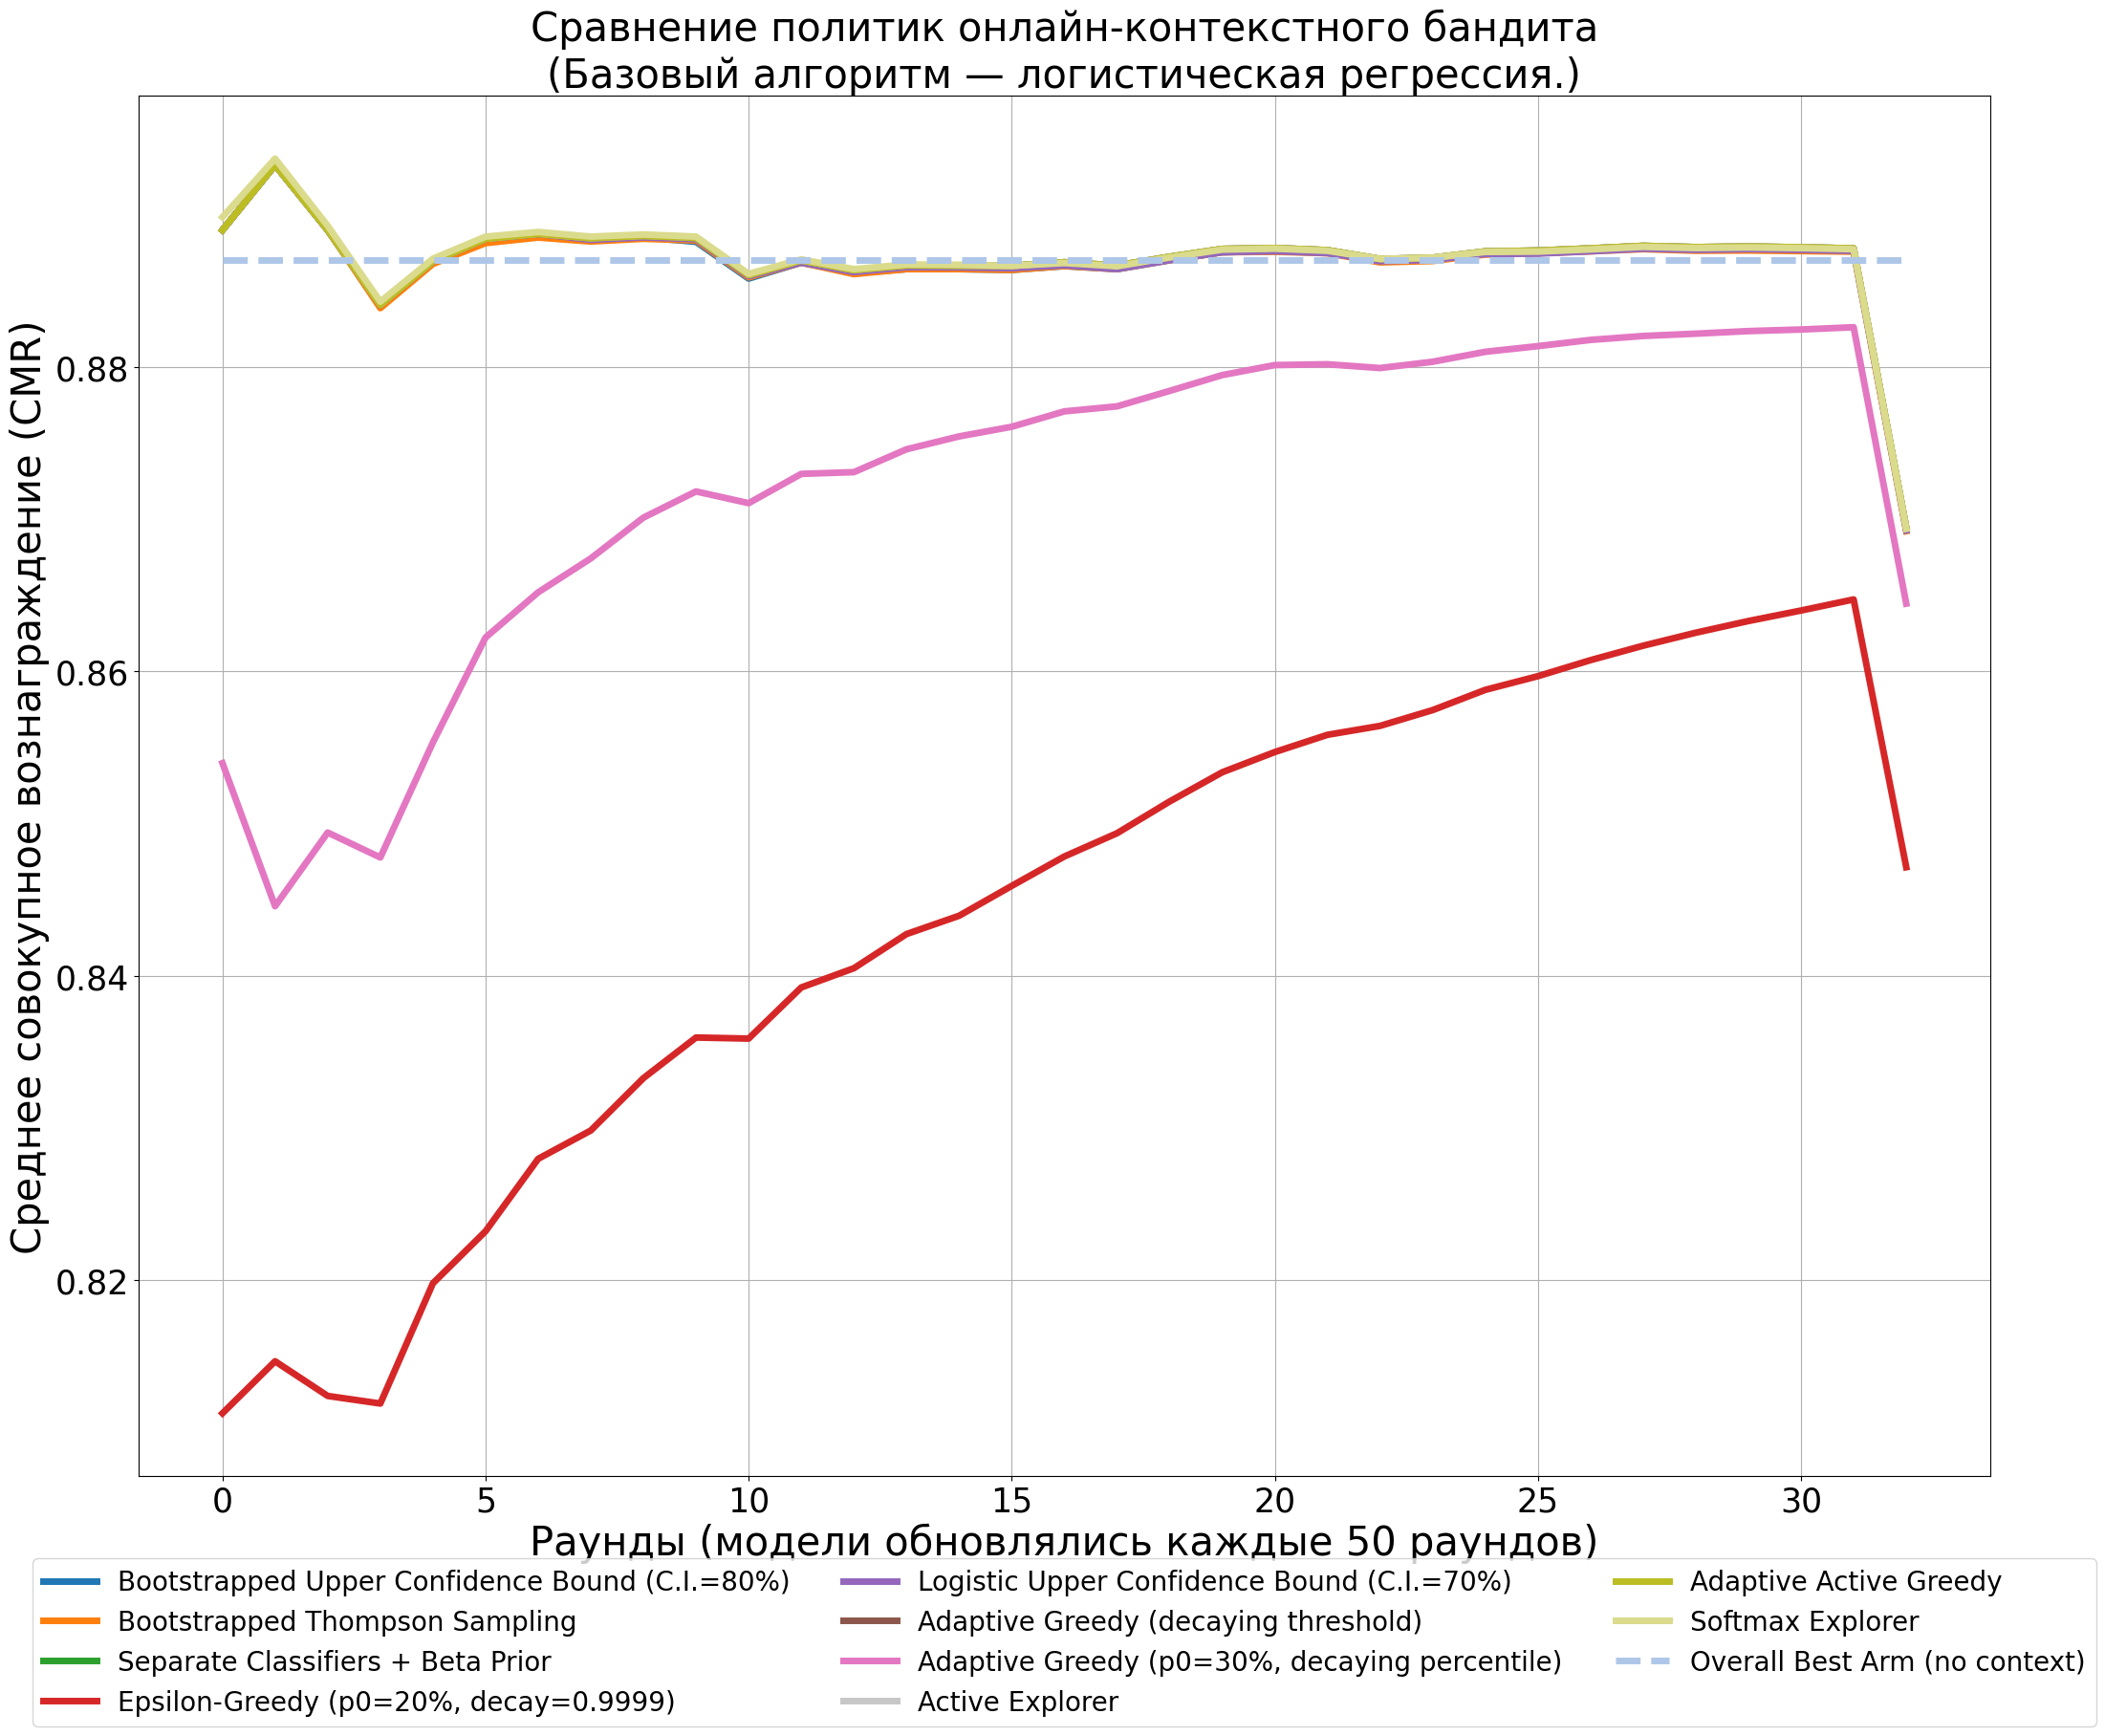

In [23]:
def get_mean_reward(reward_lst, batch_size=batch_size):
    mean_rew=list()
    for r in range(len(reward_lst)):
        mean_rew.append(sum(reward_lst[:r+1]) * 1.0 / ((r+1)*batch_size))
    return mean_rew

rcParams['figure.figsize'] = 25, 15
lwd = 5
cmap = plt.get_cmap('tab20')
colors=plt.cm.tab20(np.linspace(0, 1, 20))

ax = plt.subplot(111)
plt.plot(get_mean_reward(rewards_ucb), label="Bootstrapped Upper Confidence Bound (C.I.=80%)",linewidth=lwd,color=colors[0])
plt.plot(get_mean_reward(rewards_ts), label="Bootstrapped Thompson Sampling",linewidth=lwd,color=colors[2])
plt.plot(get_mean_reward(rewards_ovr), label="Separate Classifiers + Beta Prior",linewidth=lwd,color=colors[4])
plt.plot(get_mean_reward(rewards_egr), label="Epsilon-Greedy (p0=20%, decay=0.9999)",linewidth=lwd,color=colors[6])
plt.plot(get_mean_reward(rewards_lucb), label="Logistic Upper Confidence Bound (C.I.=70%)",linewidth=lwd,color=colors[8])
plt.plot(get_mean_reward(rewards_agr), label="Adaptive Greedy (decaying threshold)",linewidth=lwd,color=colors[10])
plt.plot(get_mean_reward(rewards_agr2), label="Adaptive Greedy (p0=30%, decaying percentile)",linewidth=lwd,color=colors[12])
#plt.plot(get_mean_reward(rewards_efr), label="Explore First (n=1,500)",linewidth=lwd,color=colors[14])
plt.plot(get_mean_reward(rewards_ac), label="Active Explorer", linewidth=lwd,color=colors[15])
plt.plot(get_mean_reward(rewards_aac), label="Adaptive Active Greedy", linewidth=lwd,color=colors[16])
plt.plot(get_mean_reward(rewards_sft), label="Softmax Explorer", linewidth=lwd,color=colors[17])
plt.plot(np.repeat(y_global.mean(axis=0).max(),len(rewards_sft)), label="Overall Best Arm (no context)",linewidth=lwd,color=colors[1],ls='dashed')

box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 1.25])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, ncol=3, prop={'size':20})


plt.tick_params(axis='both', which='major', labelsize=25)
#plt.xticks([i*20 for i in range(8)], [i*1000 for i in range(8)])


plt.xlabel('Раунды (модели обновлялись каждые 50 раундов)', size=30)
plt.ylabel('Среднее совокупное вознаграждение (CMR)', size=30)
plt.title('Сравнение политик онлайн-контекстного бандита\n(Базовый алгоритм — логистическая регрессия.)',size=30)
plt.grid()
plt.show()

In [24]:
max_last_point = list()
for i in lst_rewards:
    max_last_point.append(get_mean_reward(i)[-1])
    
model_name = [
    'bootstrapped_ucb', 
    'bootstrapped_ts', 
    'one_vs_rest', 
    'epsilon_greedy', 
    'logistic_ucb', 
    'adaptive_greedy_thr', 
    'adaptive_greedy_perc', 
#    'explore_first', 
    'active_explorer', 
    'adaptive_active_greedy', 
    'softmax_explorer'
]

In [25]:
pd.DataFrame({'model':model_name,'max_point':max_last_point}).sort_values('max_point', ascending=False)

,model,max_point
2,one_vs_rest,0.869420
5,adaptive_greedy_thr,0.869420
7,active_explorer,0.869420
8,adaptive_active_greedy,0.869420
0,bootstrapped_ucb,0.869368
9,softmax_explorer,0.869368
4,logistic_ucb,0.869265
1,bootstrapped_ts,0.869213
6,adaptive_greedy_perc,0.864452
3,epsilon_greedy,0.847139


In [26]:
check = pd.DataFrame({'target':df_train[target].values, 'bandit':one_vs_rest.predict(X_global)})

In [27]:
check.describe()

,target,bandit
count,39036.000000,39036.000000
mean,0.112973,0.995158
std,0.316563,0.069414
min,0.000000,0.000000
25%,0.000000,1.000000
50%,0.000000,1.000000
75%,0.000000,1.000000
max,1.000000,1.000000


In [28]:
check.nunique()

target    2
bandit    2
dtype: int64

In [29]:
check.groupby('bandit').count()

,target
bandit,
0,189
1,38847


In [30]:
check[check.bandit==0].shape, check[check.bandit==0].target.sum()

((189, 2), 100)

In [31]:
check[check.bandit==0].target.mean()

0.5291005291005291

In [32]:
best_actions = [1 if x == 0 else 0 for x in check.target]
lost_opportunity_cost = [x - y for x, y in zip(best_actions, check.bandit)]
print('Стоимость упущенной возможности: ', np.sum(lost_opportunity_cost))

Стоимость упущенной возможности:  -4221


Text(0.5, 1.0, 'Conf матрица')

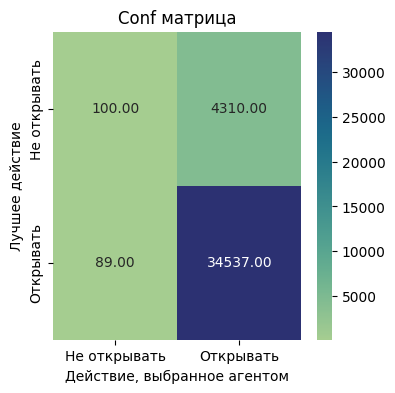

In [33]:
matplotlib.rc('figure', figsize=(4, 4))

df_cm = pd.DataFrame(confusion_matrix(best_actions, check.bandit))
df_cm.columns = ['Не открывать', 'Открывать']
df_cm.index  = ['Не открывать', 'Открывать']
sn.heatmap(df_cm, annot=True, fmt=".2f", cmap="crest")
plt.xlabel('Действие, выбранное агентом')
plt.ylabel('Лучшее действие')
plt.title('Conf матрица')

In [36]:
check_test = pd.DataFrame({'target':df_test[target].values, 'bandit':one_vs_rest.predict(df_test[fs_cols])})

In [37]:
best_actions = [1 if x == 0 else 0 for x in check_test.target]
lost_opportunity_cost = [x - y for x, y in zip(best_actions, check_test.bandit)]
print('Стоимость упущенной возможности: ', np.sum(lost_opportunity_cost))

Стоимость упущенной возможности:  -1410


Text(0.5, 1.0, 'Conf матрица')

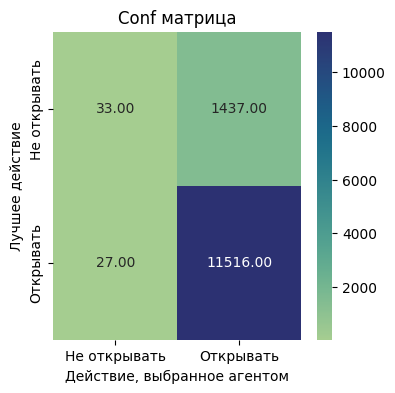

In [38]:
matplotlib.rc('figure', figsize=(4, 4))

df_cm = pd.DataFrame(confusion_matrix(best_actions, check_test.bandit))
df_cm.columns = ['Не открывать', 'Открывать']
df_cm.index  = ['Не открывать', 'Открывать']
sn.heatmap(df_cm, annot=True, fmt=".2f", cmap="crest")
plt.xlabel('Действие, выбранное агентом')
plt.ylabel('Лучшее действие')
plt.title('Conf матрица')

In [39]:
print(classification_report(best_actions, check_test.bandit))

              precision    recall  f1-score   support

           0       0.55      0.02      0.04      1470
           1       0.89      1.00      0.94     11543

    accuracy                           0.89     13013
   macro avg       0.72      0.51      0.49     13013
weighted avg       0.85      0.89      0.84     13013



---

In [40]:
### Try to free memory for the next example
del models
del bootstrapped_ucb
del bootstrapped_ts
del one_vs_rest
del epsilon_greedy
del logistic_ucb
del adaptive_greedy_thr
del adaptive_greedy_perc
del explore_first
del active_explorer
del adaptive_active_greedy
del softmax_explorer

import gc
gc.collect()

1400

---

In [46]:
from sklearn.linear_model import SGDClassifier
from contextualbandits.linreg import LinearRegression
from contextualbandits.online import LinUCB, AdaptiveGreedy, \
        SoftmaxExplorer, ActiveExplorer, EpsilonGreedy

nchoices = len(available_actions)
base_sgd = SGDClassifier(random_state=SEED, loss='log', warm_start=False)
base_ols = LinearRegression(lambda_=10., fit_intercept=True, method="sm")

## Метаэвристика с использованием различных базовых алгоритмов и конфигураций

linucb = LinUCB(nchoices = nchoices, beta_prior = None, alpha = 0.1,
                ucb_from_empty = False, random_state = SEED)

### Важно!!! Гиперпараметры по умолчанию для LinUCB в справочной статье сильно отличаются от тех, что используются в этом примере.

adaptive_active_greedy = AdaptiveGreedy(deepcopy(base_ols), nchoices = nchoices,
                                        smoothing = None, beta_prior = ((3./nchoices,4.), 2),
                                        active_choice = 'weighted', decay_type = 'percentile',
                                        decay = 0.9997, batch_train = True,
                                        random_state = SEED)
softmax_explorer = SoftmaxExplorer(deepcopy(base_sgd), nchoices = nchoices,
                                   smoothing = (1,2), beta_prior = None, batch_train = True,
                                   refit_buffer = 50, deep_copy_buffer = False, random_state = SEED)
adaptive_greedy_perc = AdaptiveGreedy(deepcopy(base_ols), nchoices = nchoices,
                                      smoothing = (1,2), beta_prior = None,
                                      decay_type = 'percentile', decay = 0.9997, batch_train = True,
                                      random_state = SEED)
active_explorer = ActiveExplorer(deepcopy(base_sgd), smoothing = None, nchoices = nchoices,
                                 beta_prior = ((3./nchoices, 4.), 2), batch_train = True, refit_buffer = 50,
                                 deep_copy_buffer = False, random_state = SEED)
epsilon_greedy_nodecay = EpsilonGreedy(deepcopy(base_ols), nchoices = nchoices,
                                       smoothing = (1,2), beta_prior = None,
                                       decay = None, batch_train = True,
                                       deep_copy_buffer = False, random_state = SEED)


models = [linucb, adaptive_active_greedy, softmax_explorer, adaptive_greedy_perc,
          active_explorer, epsilon_greedy_nodecay]

In [47]:
# Эти списки будут отслеживать вознаграждения, полученные по каждой политике.

rewards_lucb, rewards_aac, rewards_sft, rewards_agr, \
rewards_ac, rewards_egr = [list() for i in range(len(models))]

lst_rewards = [rewards_lucb, rewards_aac, rewards_sft,
               rewards_agr, rewards_ac, rewards_egr]

# Размер батча - алгоритмы будут переобучены после N раундов

batch_size = int(df_train.shape[0]*0.03)

# Начальное значение — все политики начинаются с одного и того же небольшого случайного набора действий/вознаграждений

first_batch = np.array(df_train[fs_cols])[:batch_size, :]
action_chosen = np.random.randint(nchoices, size=batch_size)
y_init = np.array([[i, -1*(i-1)] for i in df_train[target].iloc[:batch_size]])
rewards_received = y_init[np.arange(batch_size), action_chosen]
first_batch.shape, y_init.shape, rewards_received.shape

((1171, 4), (1171, 2), (1171,))

In [48]:
%%time

# Обучение модели в первый раз

for model in models:
    model.fit(X=first_batch, a=action_chosen, r=rewards_received)

CPU times: user 32.4 ms, sys: 7.31 ms, total: 39.7 ms
Wall time: 540 ms


In [49]:
# Эти список будет отслеживать, какие действия выбирает каждая политика

lst_a_lucb, lst_a_aac, lst_a_sft, lst_a_agr, \
lst_a_ac, lst_a_egr = [action_chosen.copy() for i in range(len(models))]

lst_actions = [lst_a_lucb, lst_a_aac, lst_a_sft,
               lst_a_agr, lst_a_ac, lst_a_egr]

# Раунды моделируются на основе полного набора данных

def simulate_rounds_stoch(model, rewards, actions_hist, X_batch, y_batch, rnd_seed):
    np.random.seed(rnd_seed)
    
    ## Выбор действий для этого батча
    actions_this_batch = model.predict(X_batch).astype('uint8')
    
    # Отслеживание суммы полученных вознаграждений
    rewards.append(y_batch[np.arange(y_batch.shape[0]), actions_this_batch].sum())
    
    # Добавление этого батча в историю выбранных действий
    new_actions_hist = np.append(actions_hist, actions_this_batch)
    
    # Награды, полученные сейчас
    rewards_batch = y_batch[np.arange(y_batch.shape[0]), actions_this_batch]
    
    # Теперь переобучаем алгоритмы после наблюдения за этими новыми наградами
    np.random.seed(rnd_seed)
    model.partial_fit(X_batch, actions_this_batch, rewards_batch)
    
    return new_actions_hist

In [50]:
# Запускаем все симуляции

for i in tqdm(range(int(np.floor(X_global.shape[0] / batch_size)))):
    batch_st = (i + 1) * batch_size
    batch_end = (i + 2) * batch_size
    batch_end = np.min([batch_end, X_global.shape[0]])
    
    X_batch = X_global[batch_st:batch_end, :]
    y_batch = y_global[batch_st:batch_end, :]
    
    for model in range(len(models)):
        lst_actions[model] = simulate_rounds_stoch(model=models[model],
                                                   rewards=lst_rewards[model],
                                                   actions_hist=lst_actions[model],
                                                   X_batch=X_batch, 
                                                   y_batch=y_batch,
                                                   rnd_seed = batch_st)

100%|██████████| 33/33 [00:50<00:00,  1.53s/it]


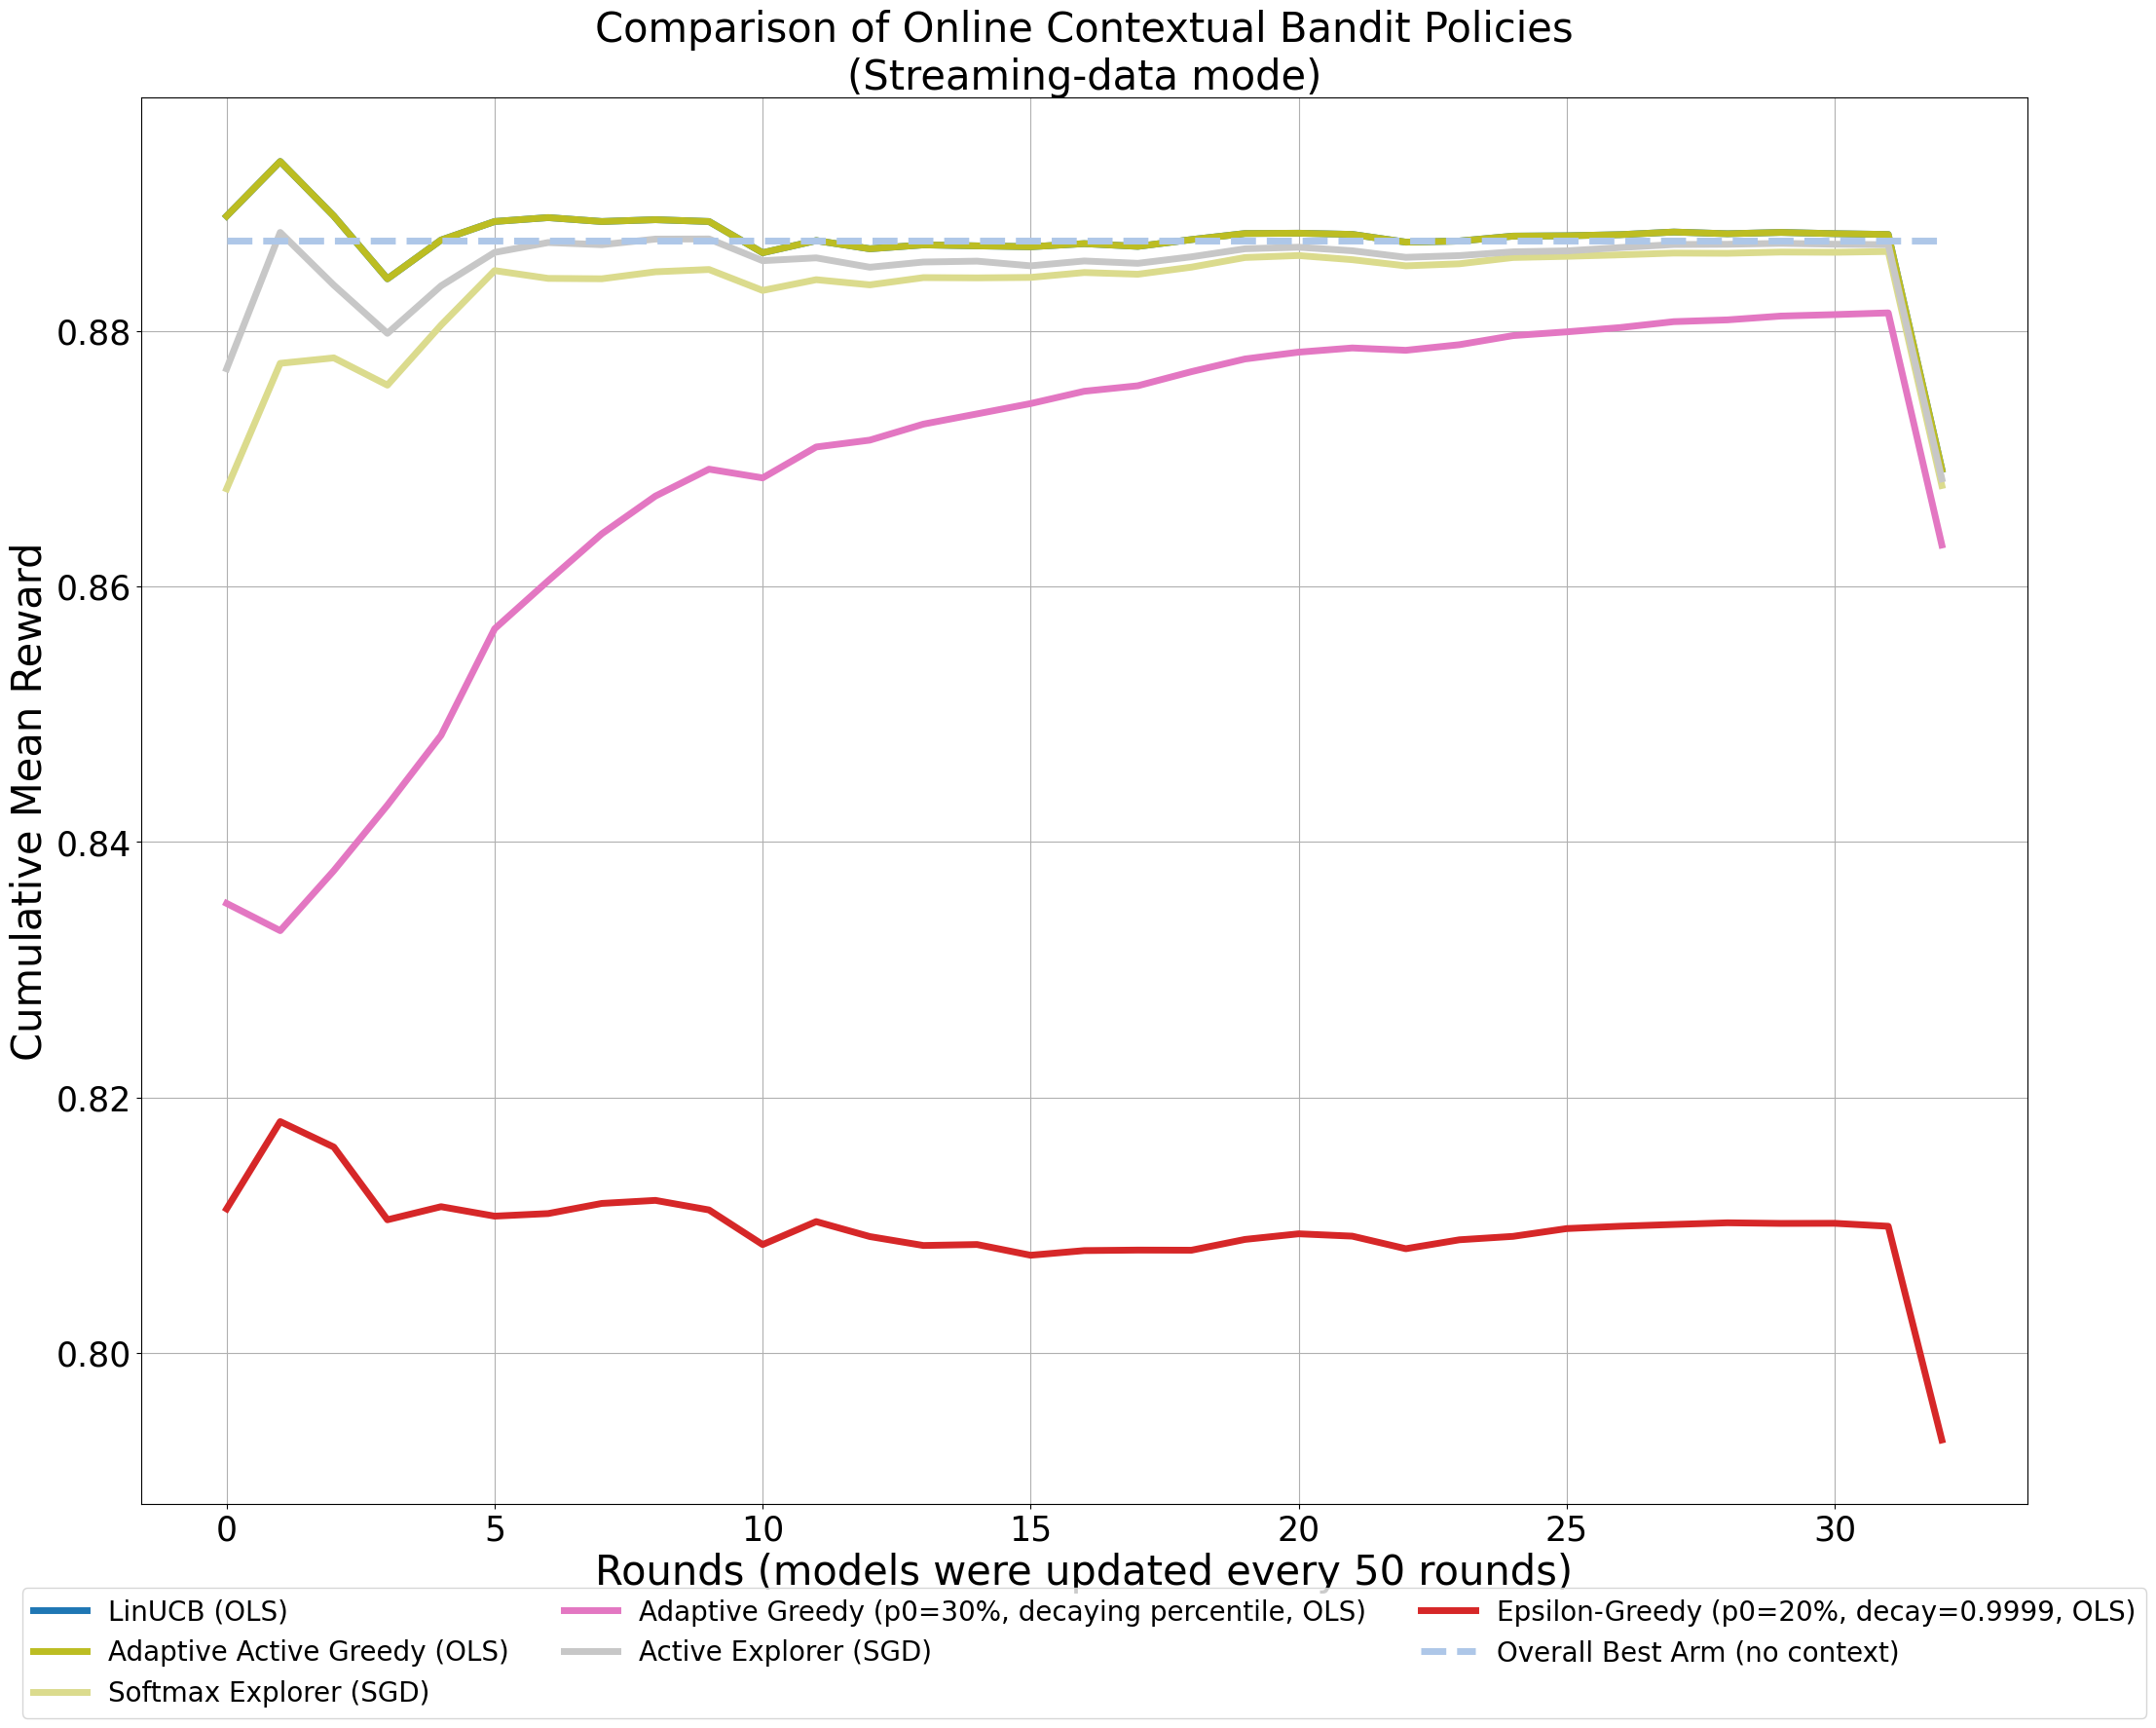

In [51]:
def get_mean_reward(reward_lst, batch_size=batch_size):
    mean_rew=list()
    for r in range(len(reward_lst)):
        mean_rew.append(sum(reward_lst[:r+1]) * 1.0 / ((r+1)*batch_size))
    return mean_rew

rcParams['figure.figsize'] = 25, 15
lwd = 5
cmap = plt.get_cmap('tab20')
colors=plt.cm.tab20(np.linspace(0, 1, 20))
rcParams['figure.figsize'] = 25, 15

ax = plt.subplot(111)
plt.plot(get_mean_reward(rewards_lucb), label="LinUCB (OLS)", linewidth=lwd,color=colors[0])
plt.plot(get_mean_reward(rewards_aac), label="Adaptive Active Greedy (OLS)", linewidth=lwd,color=colors[16])
plt.plot(get_mean_reward(rewards_sft), label="Softmax Explorer (SGD)", linewidth=lwd,color=colors[17])
plt.plot(get_mean_reward(rewards_agr), label="Adaptive Greedy (p0=30%, decaying percentile, OLS)", linewidth=lwd,color=colors[12])
plt.plot(get_mean_reward(rewards_ac), label="Active Explorer (SGD)", linewidth=lwd,color=colors[15])
plt.plot(get_mean_reward(rewards_egr), label="Epsilon-Greedy (p0=20%, decay=0.9999, OLS)",linewidth=lwd,color=colors[6])
plt.plot(np.repeat(y_global.mean(axis=0).max(),len(rewards_sft)), label="Overall Best Arm (no context)",linewidth=lwd,color=colors[1],ls='dashed')

box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 1.25])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, ncol=3, prop={'size':20})


plt.tick_params(axis='both', which='major', labelsize=25)
#plt.xticks([i*20 for i in range(8)], [i*1000 for i in range(8)])


plt.xlabel('Rounds (models were updated every 50 rounds)', size=30)
plt.ylabel('Cumulative Mean Reward', size=30)
plt.title('Comparison of Online Contextual Bandit Policies\n(Streaming-data mode)',size=30)
plt.grid()
plt.show()

---
# Попробуем сделать rewards не только 0,1

In [101]:
nchoices = len(available_actions)
base_algorithm = LogisticRegression(solver='lbfgs', warm_start=True)
beta_prior = ((3./nchoices, 4), 2) # пока не будет хотя бы 2 наблюдений каждого класса, будем использовать это предварительное
beta_prior_ucb = ((5./nchoices, 4), 2) # UCB дает более высокие числа, следовательно, более высокий положительный априорный
beta_prior_ts = ((2./np.log2(nchoices), 4), 2)
### Важно!!! значения по умолчанию для beta_prior будут изменены в версии 0.3

## Базовый алгоритм встроен в различные метаэвристики
bootstrapped_ucb = BootstrappedUCB(deepcopy(base_algorithm), nchoices = nchoices,
                                   beta_prior = beta_prior_ucb, percentile = 80,
                                   random_state = SEED)
bootstrapped_ts = BootstrappedTS(deepcopy(base_algorithm), nchoices = nchoices,
                                 beta_prior = beta_prior_ts, random_state = SEED)
one_vs_rest = SeparateClassifiers(deepcopy(base_algorithm), nchoices = nchoices,
                                  beta_prior = beta_prior, random_state = SEED)
epsilon_greedy = EpsilonGreedy(deepcopy(base_algorithm), nchoices = nchoices,
                               beta_prior = beta_prior, random_state = SEED)
logistic_ucb = LogisticUCB(nchoices = nchoices, percentile = 70,
                           beta_prior = beta_prior_ts, random_state = SEED)
adaptive_greedy_thr = AdaptiveGreedy(deepcopy(base_algorithm), nchoices=nchoices,
                                     decay_type='threshold',
                                     beta_prior = beta_prior, random_state = SEED)
adaptive_greedy_perc = AdaptiveGreedy(deepcopy(base_algorithm), nchoices = nchoices,
                                      decay_type='percentile', decay=0.9997,
                                       beta_prior=beta_prior, random_state = SEED)
active_explorer = ActiveExplorer(deepcopy(base_algorithm), nchoices = nchoices,
                                 beta_prior=beta_prior, random_state = SEED)
adaptive_active_greedy = AdaptiveGreedy(deepcopy(base_algorithm), nchoices = nchoices,
                                        active_choice='weighted', decay_type='percentile', decay=0.9997,
                                        beta_prior=beta_prior, random_state = SEED)
softmax_explorer = SoftmaxExplorer(deepcopy(base_algorithm), nchoices = nchoices,
                                   beta_prior=beta_prior, random_state = SEED)

models = [
          bootstrapped_ucb, 
          bootstrapped_ts, 
          one_vs_rest, 
          epsilon_greedy, 
          logistic_ucb,
          adaptive_greedy_thr, 
          adaptive_greedy_perc, 
          active_explorer,
          adaptive_active_greedy, 
          softmax_explorer
         ]

In [102]:
def reward(df, penalty=0):
    if df.action==1:
        if df.target==0:
            return 1
        else:
            return penalty
    else:
        return 0

In [103]:
df_train['action'] = np.random.randint(nchoices, size=df_train.shape[0])
df_train['reward'] = df_train.apply(lambda x: reward(x, -3), axis=1)

In [110]:
# Эти списки будут отслеживать вознаграждения, полученные по каждой политике.

(
    rewards_ucb, 
    rewards_ts, 
    rewards_ovr, 
    rewards_egr, 
    rewards_lucb,
    rewards_agr, 
    rewards_agr2, 
#    rewards_efr, 
    rewards_ac,
    rewards_aac, 
    rewards_sft
) = [list() for i in range(len(models))]

lst_rewards = [
    rewards_ucb, 
    rewards_ts, 
    rewards_ovr, 
    rewards_egr, 
    rewards_lucb,
    rewards_agr, 
    rewards_agr2, 
#    rewards_efr, 
    rewards_ac,
    rewards_aac, 
    rewards_sft
]

# Размер партии - алгоритмы будут переобучены после N раундов

batch_size = int(df_train.shape[0]*0.03)

first_batch = np.array(df_train[fs_cols])[:batch_size, :]
action_chosen = np.random.randint(nchoices, size=batch_size)
rewards_received = np.random.randint(nchoices, size=batch_size)
#rewards_received = np.array(df_train['reward'])[:batch_size]
first_batch.shape, action_chosen.shape, rewards_received.shape

((1171, 4), (1171,), (1171,))

In [111]:
np.unique(rewards_received)

array([0, 1])

In [112]:
%%time

# Обучение модели в первый раз

for model in models:
    model.fit(X=first_batch, a=action_chosen, r=rewards_received)

CPU times: user 430 ms, sys: 105 ms, total: 535 ms
Wall time: 1.25 s
